# Mean equality test applied to varying mixing weights models

Margaux Thorez

## 1- Contextualization

Let's denote $m_1$ and $m_2$ the means of two groups 1 and 2 (the average duration of work stoppages in our case study). To test the equality of the means, the null hypothesis $H_0$ is that the two groups have equal means. The test problem considered is
 $$ H_0 : m_1 = m_2   \hspace{0.4cm}  \mbox{ vs}  \hspace{0.4cm}  H_1 : m_1 \neq m_2. $$ 

We can use the test statistic:
$$ T_m' = \frac{\hat{m}_1 - \hat{m}_2}{\sqrt{\hat{V}'}},$$ with $\hat{m}_1$ and $\hat{m}_2$ the means estimated using the M-estimators, and $$V' = (a_1(A) - a_2(A))^2 \frac{sigma_A^2}{n_A} + (a_1(B) - a_2(B))^2 \frac{sigma_B^2}{n_B},$$
with $\sigma_A^2$ and $\sigma_B^2$ the variances of samples $A$ and $B$ respectively.

Under the null hypothesis $H_0$, the distribution of $T_m'$ asymptotically follows the standard Gaussian distribution, i.e.
$$ T_m' \xrightarrow[n\rightarrow +\infty ]{\mathcal{L}} \mathcal{N}(0,1).$$

We will illustrate this result with a few simulations. In the case with censorship, this is not the good normalisation but it gives us an idea of the result. 

## 2- Libraries import

In [1]:
#Libraries import
#Basic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import *
from scipy import stats
import random
import statistics

#scikit-survival Kaplan-Meier estimator
from sksurv.nonparametric import kaplan_meier_estimator

#Interpolation
from scipy.interpolate import interp1d

#CVXPY for convex optimization problems.
import cvxpy as cp

#Numba import
from numba import njit, vectorize

#Parallelization modules
from sklearn.utils._joblib import Parallel, delayed

#Kolmogorov-Smirnov Test
from scipy.stats import ks_2samp
from scipy.stats import kstest

#Normality Test
from scipy.stats import skew
from scipy.stats import kurtosis

from scipy.stats import norm
from tqdm import tqdm

#Notebook
from jyquickhelper import add_notebook_menu
import warnings
warnings.filterwarnings('ignore')

In [2]:
add_notebook_menu()

## 3- Base model - optimized functions

In [3]:
#Function that creates the base sample in a mixture according to the chosen law
def InitializeMatriceX(law, lambd1, lambd2, P_1, size):
    #Matrices X_A1 and X_A2
    if law == "exponnential":
        X_1 = stats.expon.rvs(scale=lambd1, size=size)
        X_2 = stats.expon.rvs(scale=lambd2, size=size)
    if law == "pareto":
        X_1_v1 = stats.pareto.rvs(b=3, size=size)
        X_1 = (2/3)*lambd1*(X_1_v1-1)
        X_2_v1 = stats.pareto.rvs(b=3, size=size)
        X_2 = (2/3)*lambd2*(X_2_v1-1)
    if law == "weibull":
        X_1 = stats.weibull_min.rvs(c=2, scale=lambd1, size=size)
        X_2 = stats.weibull_min.rvs(c=2, scale=lambd2, size=size)    
    if law == "gamma" :
        X_1 = stats.gamma.rvs(a=lambd1, size=size)
        X_2 = stats.gamma.rvs(a=lambd2, size=size)
    #Matrice RA
    R = stats.bernoulli.rvs(P_1, size=size)
    X = R*X_1 + (1-R)*X_2
    return X

In [4]:
#Function to include censorship
@njit #(parallel=True)
def Y_ind_Allocation(Y_ind, Y, C, X):
    for i in range(len(X)):
        if Y[i]<C[i]: 
            Y_ind[i]=True
    return Y_ind

In [5]:
def MonObjectif( m, echantillon, NbA, NbB, Aa, Ab ):
    somme = 0
    for i in range( len( echantillon ) ):
        if ( i < NbA ):
            somme += Aa * numpy.absolute( echantillon[ i ] - m ) / NbA
        else:
            somme += Ab * numpy.absolute( echantillon[ i ] - m )/ NbB
    return somme   

In [6]:
def Mmoyenne( m, echantillon, n ):
    somme = 0
    for i in range( len( echantillon ) ):
        somme += ( echantillon[ i ] - m )**2 / n
    return somme

## 4- Mean equality Test without censorship 

In [7]:
def RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2):
    P = np.array([[P_A1, P_A2], [P_B1, P_B2]])
    # Samples
    X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    
    #Kaplan-Meier estimators
    Y_A = X_A
    Y_A_ind = [True for i in range(len(Y_A))]
    time_A, S_A_est = kaplan_meier_estimator(Y_A_ind, Y_A)
    
    sigmaA = statistics.variance(Y_A)
    
    Y_B = X_B
    Y_B_ind = [True for i in range(len(Y_B))]
    time_B, S_B_est = kaplan_meier_estimator(Y_B_ind, Y_B)
    
    sigmaB = statistics.variance(Y_B)
    
    #M_inv matrix in Rhyzov case
    M_inv = np.linalg.inv(P)
    
    #Mean of group A
    xinf = 0
    xsup = 100
    nbpts = 1000 + 1
    x = np.linspace( xinf, xsup, nbpts )
    ObjFctLow = 10000
    mTempo = 0
    for mtent in x:
        ObjTempo = Mmoyenne( mtent, Y_A, nA)
        if ObjTempo < ObjFctLow:
            ObjFctLow = ObjTempo
            mTempo = mtent
    mA = mTempo
    
    #Mean of group B
    xinf = 0
    xsup = 100
    nbpts = 1000 + 1
    x = np.linspace( xinf, xsup, nbpts )
    ObjFctLow = 10000
    mTempo = 0
    for mtent in x:
        ObjTempo = Mmoyenne( mtent, Y_B, nB)
        if ObjTempo < ObjFctLow:
            ObjFctLow = ObjTempo
            mTempo = mtent
    mB = mTempo
    
    m1 = M_inv[0][0]*mA + M_inv[0][1]*mB
    m2 = M_inv[1][0]*mA + M_inv[1][1]*mB
    
    
    diff = (m1 - m2)/sqrt((M_inv[0][0] - M_inv[1][0])**2*(sigmaA/nA) + (M_inv[0][1] - M_inv[1][1])**2*(sigmaB/nB))
    
    return (diff)

In [8]:
def RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    
    #Initialization of parallelization parameters
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    #RunSimulation
    ComputedBlocks = ParallelSetUp([delayed(RunSimulation)(law=law, nA=nA, nB=nB, lambd1=lambd1, lambd2=lambd2, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2) for k in range(K)])

    #Concatenation into array
    List_results = np.array([diff for diff  in ComputedBlocks], dtype=np.dtype(object))

    #return ComputedBlocks
    return  List_results

#### Parameters choice

In [9]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 50

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1


In [10]:
#Inverted weight matrix
M = np.array([[P_A1, P_A2],[P_B1, P_B2]])
M_inv = np.linalg.inv(M)
print(M_inv)

[[ 1.5        -0.5       ]
 [-0.16666667  1.16666667]]


#### Results of one simulation

In [11]:
RunSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2)

0.8062899798370889

#### Results of K simulations

In [12]:
#Number of repetitions
K = 1000

In [13]:
List_results = RunParallelSimulation(law, nA, nB, lambd1, lambd2, P_A1, P_A2, P_B1, P_B2, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')

In [14]:
List_results = List_results.tolist()

Text(0.5, 1.0, "Analytical vs. Estimated PDF of $T_m'$")

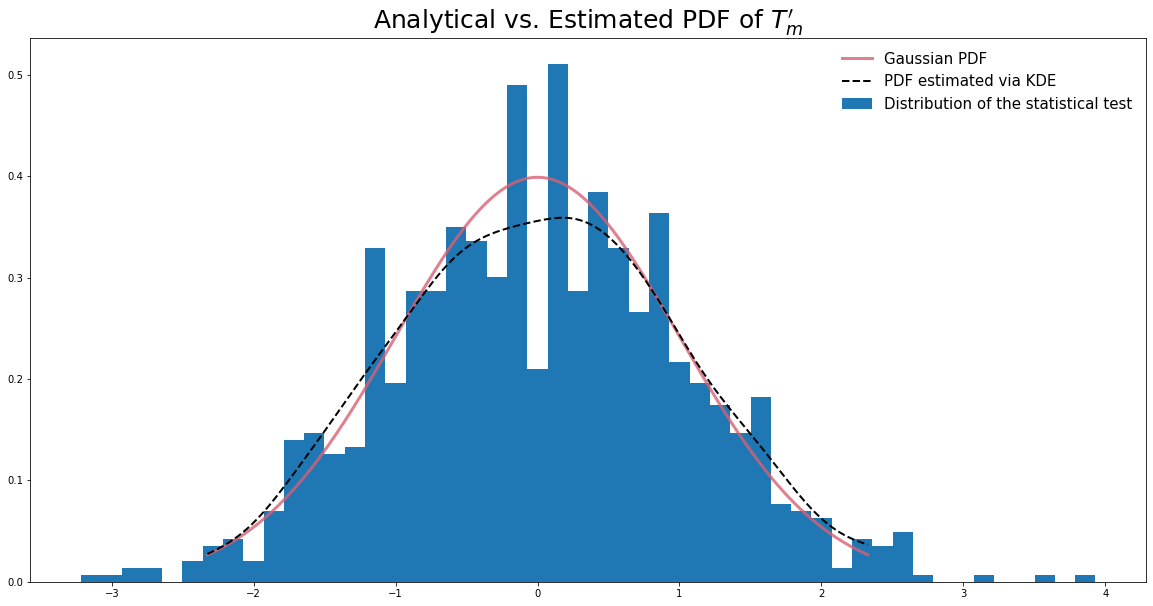

In [15]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=List_results)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(List_results,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title("Analytical vs. Estimated PDF of $T_m'$", fontsize = 25)

In [16]:
#Compute mean of the statistic
print(np.mean(List_results))

#Compute variance of the statistic
print(np.var(List_results))

0.01979311766260572
1.0879372737892532


In [17]:
# Calculate the skewness
print(skew(List_results, axis=0, bias=True))

# Calculate the kurtosis
print(kurtosis(List_results, axis=0, fisher =  False, bias=True))

0.08443783888685849
3.0355960520644842


In [18]:
#Perform Kolmogorov-Smirnov test for normality 
kstest(List_results, 'norm')

KstestResult(statistic=0.03287527547873581, pvalue=0.2249666365629034, statistic_location=0.2920486214602146, statistic_sign=-1)

## 5- Mean equality Test with censorship 

For now, we juste take into account the exponnentiel distribution to facilitate the computation of the expected median.

In [19]:
def RunSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2):
    #The model argument can be either "Ryzhov" or "Maiboroda"
    P = np.array([[P_A1, P_A2], [P_B1, P_B2]])
    # Samples
    X_A = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_A1, size=nA)
    X_B = InitializeMatriceX(law=law, lambd1=lambd1, lambd2=lambd2, P_1=P_B1, size=nB)
    
    #Initialization of matrices C_A and C_B
    C_A = InitializeMatriceX(law=law, lambd1=lambdC, lambd2=lambdC, P_1=1, size=nA)
    C_B = InitializeMatriceX(law=law, lambd1=lambdC, lambd2=lambdC, P_1=1, size=nB)
    
    #Kaplan-Meier estimators
    #Independent copy of X_A and X_B
    Y_A = X_A
    Y_B = X_B
    #Initializing Y_A_ind and Y_B_ind
    Y_A_ind = np.full(shape=Y_A.shape, fill_value=False)
    Y_B_ind = np.full(shape=Y_B.shape, fill_value=False)
    #Updating Y_A_ind and Y_B_ind
    Y_A = np.minimum(C_A, X_A)
    Y_A_ind = Y_ind_Allocation(Y_ind=Y_A_ind, Y=Y_A, C=C_A, X=X_A)
    Y_B = np.minimum(C_B, X_B)
    Y_B_ind = Y_ind_Allocation(Y_ind=Y_B_ind, Y=Y_B, C=C_B, X=X_B)
    
    sigmaA = statistics.variance(Y_A)
    sigmaB = statistics.variance(Y_B)

    #M_inv matrix in Rhyzov case
    M_inv = np.linalg.inv(P)
    
    #Mean of group A
    xinf = 0
    xsup = 100
    nbpts = 1000 + 1
    x = np.linspace( xinf, xsup, nbpts )
    ObjFctLow = 10000
    mTempo = 0
    for mtent in x:
        ObjTempo = Mmoyenne( mtent, Y_A, nA)
        if ObjTempo < ObjFctLow:
            ObjFctLow = ObjTempo
            mTempo = mtent
    mA = mTempo
    
    #Mean of group B
    xinf = 0
    xsup = 100
    nbpts = 1000 + 1
    x = np.linspace( xinf, xsup, nbpts )
    ObjFctLow = 10000
    mTempo = 0
    for mtent in x:
        ObjTempo = Mmoyenne( mtent, Y_B, nB)
        if ObjTempo < ObjFctLow:
            ObjFctLow = ObjTempo
            mTempo = mtent
    mB = mTempo
    
    m1 = M_inv[0][0]*mA + M_inv[0][1]*mB
    m2 = M_inv[1][0]*mA + M_inv[1][1]*mB
    
    
    diff = (m1 - m2)/sqrt((M_inv[0][0] - M_inv[1][0])**2*(sigmaA/nA) + (M_inv[0][1] - M_inv[1][1])**2*(sigmaB/nB))
    
    return (diff)

In [20]:
def RunParallelSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs'):
    
    # Initialisation des paramètres de parallélisation
    ParallelSetUp = Parallel(n_jobs=NJobs, verbose=Verbose, pre_dispatch=PreDispatch, prefer="threads")
    
    # Entrainement de l'Estimateur sur les différentes observations de Train
    ComputedBlocks = ParallelSetUp([delayed(RunSimulationCensorship)(law=law, nA=nA, nB=nB, lambd1=lambd1, lambd2=lambd2, lambdC=lambdC, P_A1=P_A1, P_A2=P_A2, P_B1=P_B1, P_B2=P_B2) for k in range(K)])

    #Concatenation into array
    List_results = np.array([result for result in ComputedBlocks], dtype=np.dtype(object)) # peut etre que dtype array est approprié

    #return ComputedBlocks
    return List_results

#### Parameters choice

In [21]:
#Simulations
#Parameters choice (choose among "exponnential", "pareto", "weibull" and "gamma")
law = "exponnential" 

#Sample sizes (we have chosen nA = nB but it is possible to change these parameters)
n = 10000
nA = round(n/2)
nB = n - nA

#Mixture parameters
lambd1 = 50
lambd2 = 50

#Censorship parameters
lambdC = 500

#Weight selection (note that we must have P_A1 + P_A2 = 1 and P_B1 + P_B2 = 1)
P_A1 = 0.7
P_A2 = 0.3
P_B1 = 0.1
P_B2 = 0.9

#Threshold direction
direction = 1


#### Results of one simulation

In [22]:
RunSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2)

-0.5464308013552936

#### Results of K simulations

In [23]:
#Number of repetitions
K = 1000

In [24]:
List_results= RunParallelSimulationCensorship(law, nA, nB, lambd1, lambd2, lambdC, P_A1, P_A2, P_B1, P_B2, K, NJobs=-1, Verbose=0, PreDispatch='2*n_jobs')

In [25]:
List_results = List_results.tolist()

Text(0.5, 1.0, "Analytical vs. Estimated PDF of $T_m'$")

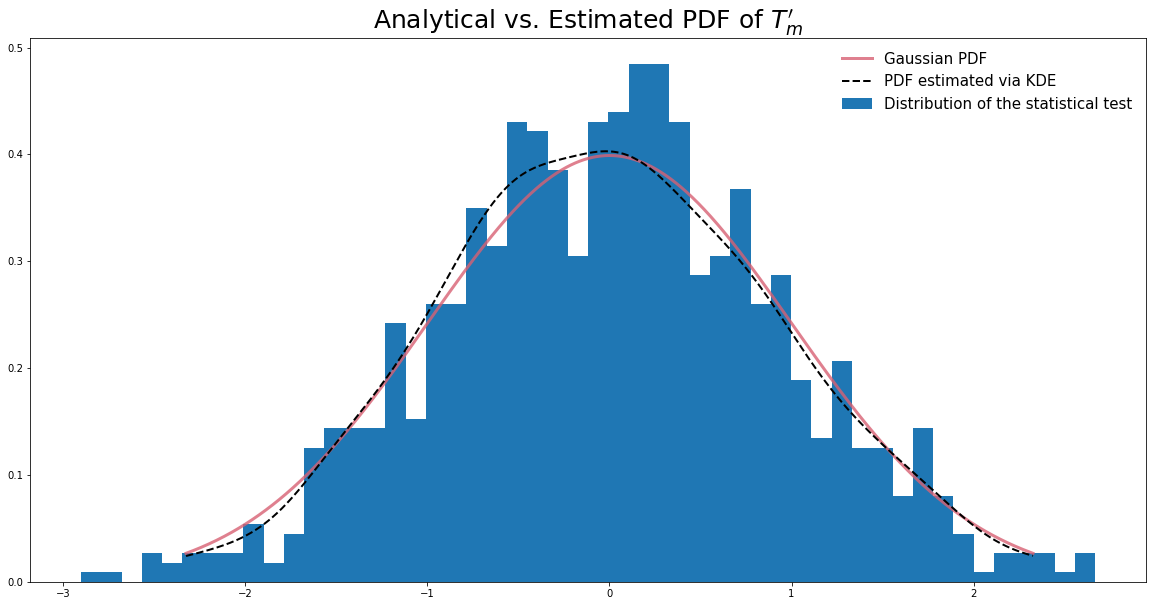

In [26]:
#Graphical representation of the distribution
dist = stats.norm()
x = np.linspace(start=stats.norm.ppf(0.01), stop=stats.norm.ppf(0.99), num=K)
gkde = stats.gaussian_kde(dataset=List_results)

fig, ax = plt.subplots(figsize=(20, 10)) 
ax.hist(List_results,bins=50, density=True, label="Distribution of the statistical test")
ax.plot(x, dist.pdf(x), linestyle='solid', c='#D86173', lw=3, alpha=0.8, label='Gaussian PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2, label='PDF estimated via KDE')
ax.legend(loc='best', frameon=False, fontsize = 15)
ax.set_title("Analytical vs. Estimated PDF of $T_m'$", fontsize = 25)

In [27]:
#Compute mean of the statistic
print(np.mean(List_results))

#Compute variance of the statistic
print(np.var(List_results))

-0.012132882951222584
0.8904670260448128


In [28]:
#Calculate the skewness
print(skew(List_results, axis=0, bias=True))

#Calculate the kurtosis
print(kurtosis(List_results, axis=0, fisher =  False, bias=True))

0.04245412221471721
2.8689328250215724


In [29]:
#Perform Kolmogorov-Smirnov test for normality 
kstest(List_results, 'norm')

KstestResult(statistic=0.03798639551180105, pvalue=0.10876543743555267, statistic_location=0.3398456194279857, statistic_sign=1)